# 支持向量机代码

支持向量机（SVM）是一类非常强大且灵活的有监督算法，既适用于分类问题，也适用于回归问题。
在本章中，我们将探讨支持向量机背后的直觉以及它们在分类问题中的应用。

我们从标准的导入语句开始：


In [254]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from scipy import stats

我们将关注**判别式分类（discriminative classification）**。直接寻找一条线（在二维空间中）、一条曲线，或者一个流形（在高维空间中），用于将不同类别的样本分开。

举个例子，假设我们面对一个分类任务，其中两个类别的样本点分布明显（见下图）：

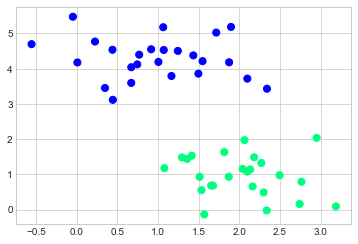

In [255]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter');

这些线条虽然**差异极大**，但都可以完美地区分两类样本。
然而，哪条线被选择将影响对新样本的分类结果（例如图中标记为 "X" 的新点）。
显然，单纯靠“画一条线分隔两类”的直觉还不够，我们需要更深层次的思考。

## 支持向量机：最大化间隔

支持向量机提供了一种改进这一点的方法。
直觉上，与其只画一条“零宽度”的分隔线，不如围绕分隔线创建一个**间隔带（margin）**，其宽度由最近的点决定。
如下图所示，这是该方法的一个示意图：



### 支持向量机

我们来看一个实际拟合的例子：我们将使用 Scikit-Learn 的支持向量分类器（`SVC`）在这组数据上训练一个支持向量机模型。
此处我们暂时使用线性核函数（linear kernel）。

In [256]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

为了更直观地理解支持向量机的决策边界，我们先定义一个简便的绘图函数，用于可视化分类结果（见下图）：

In [257]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, edgecolors='black',
                   facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

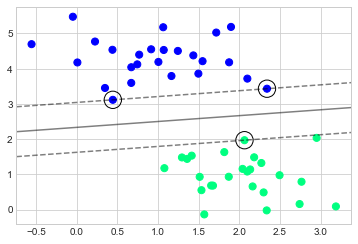

In [258]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
plot_svc_decision_function(model);

这条线就是在两类样本之间**最大化间隔**的决策边界。
注意，部分训练点**刚好贴着这个间隔带**，在下图中被圈了出来。
这些点就是拟合中起关键作用的元素，被称为**支持向量（support vectors）**，这也是“支持向量机”这一名称的由来。
在 Scikit-Learn 中，这些点的坐标存储在分类器的 `support_vectors_` 属性中：

In [259]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

### 超越线性边界：核函数 SVM

支持向量机真正强大之处在于它可以与\*\*核函数（kernel）\*\*结合使用。
通过将数据投影到一个由多项式或高斯基函数定义的高维空间，我们就可以用线性模型拟合非线性关系。

在 SVM 中也可以使用类似的想法。
为了说明为何需要核函数，我们看一组**线性不可分**的数据（见下图）：

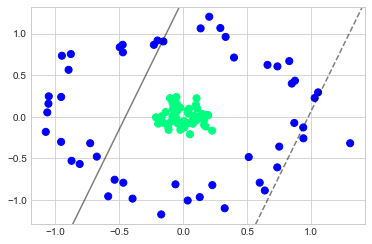

In [260]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
plot_svc_decision_function(clf, plot_support=False);

显然，**无论怎样画线，都无法**将这组数据用直线分开。
但是我们可以借鉴“基函数回归”的思路：
将数据投影到更高维度的空间中，在那个空间里再寻找一个线性分隔面。

例如，我们可以定义一个以数据中心为核心的**径向基函数（RBF）**，从而增加一个新的维度：

In [261]:
r = np.exp(-(X ** 2).sum(1))

我们可以通过三维图来可视化这个额外的维度，如下所示：

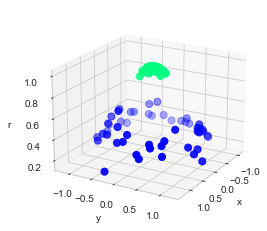

In [262]:
from mpl_toolkits import mplot3d

ax = plt.subplot(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='winter')
ax.view_init(elev=20, azim=30)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('r');


在增加这一维度后，数据变得**可以用一个简单的分隔平面**（比如 *r*=0.7）线性分离。

不过需要注意：这个投影是我们人为选择和调试的；
如果我们没有把径向基函数的中心放对位置，就不会看到这么清晰的可分结果。
而这种人为选择的需要是个问题——我们希望**自动找到合适的基函数**。

一种策略是：对每一个样本点都建立一个基函数，让 SVM 自行从中筛选。
这种基函数变换被称为**核变换（kernel transformation）**，其本质是基于每对样本点之间的相似度关系（kernel）。

这种策略的潜在问题是：如果你有 \$N\$ 个样本，就要映射到 \$N\$ 维，计算量可能会迅速变得庞大。
不过，有一个非常巧妙的技术叫做**核技巧（kernel trick）**，它允许我们在**不显式构建 \$N\$ 维表示**的前提下完成拟合。
这个核技巧正是 SVM 强大的原因之一。

在 Scikit-Learn 中，我们只需要把 SVM 的 `kernel` 参数从 `'linear'` 改为 `'rbf'`，就可以使用核 SVM 了：

In [263]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

我们可以再次使用前面定义的绘图函数来展示拟合效果和支持向量（见下图）：

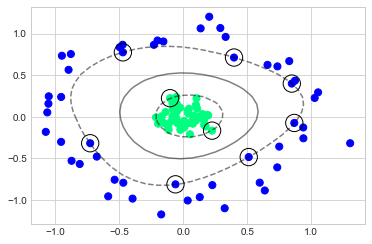

In [264]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

使用这种核支持向量机（Kernel SVM），我们得到了一个**非线性的决策边界**。
核变换的策略在机器学习中很常见：它可以将快速的线性方法转化为快速的非线性方法，尤其适用于可以使用核技巧的模型。

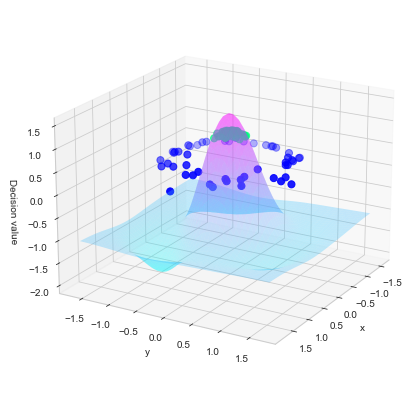

In [265]:
# 创建3D图形
fig = plt.figure(figsize=(10, 7))
ax = plt.subplot(projection='3d')

# 绘制散点图
ax.scatter(X[:, 0], X[:, 1], r, c=y, s=50, cmap='winter')

# 构造超平面
xx, yy = np.meshgrid(np.linspace(X[:, 0].min()-0.5, X[:, 0].max()+0.5, 50),
                     np.linspace(X[:, 1].min()-0.5, X[:, 1].max()+0.5, 50))
grid = np.c_[xx.ravel(), yy.ravel()]
ZZ = clf.decision_function(grid).reshape(xx.shape)

# 绘制超平面
ax.plot_surface(xx, yy, ZZ, alpha=0.3, cmap='cool')

# 设置坐标轴和视角
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Decision value')
ax.view_init(elev=20, azim=30)


### 调整 SVM：软间隔

前面的讨论都是基于“干净”的数据集——存在理想的分隔边界。
但现实中的数据往往存在**重叠**，例如如下图所示的数据：

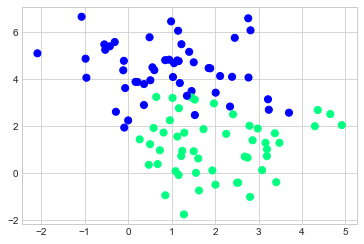

In [266]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter');

为了应对这种情况，SVM 引入了一个调整参数，允许我们“软化”决策边界：
也就是说，允许一些样本**进入间隔带**，以便取得更好的整体拟合效果。
这个边界硬度由一个超参数 `C` 控制：

* 如果 `C` 很大，边界会非常“硬”，几乎不允许任何点落入间隔带；
* 如果 `C` 较小，边界就会“软”一些，允许部分点进入间隔，以换取整体的更优拟合。

下图展示了不同 `C` 值对最终模型拟合的影响，以及间隔软化的过程：

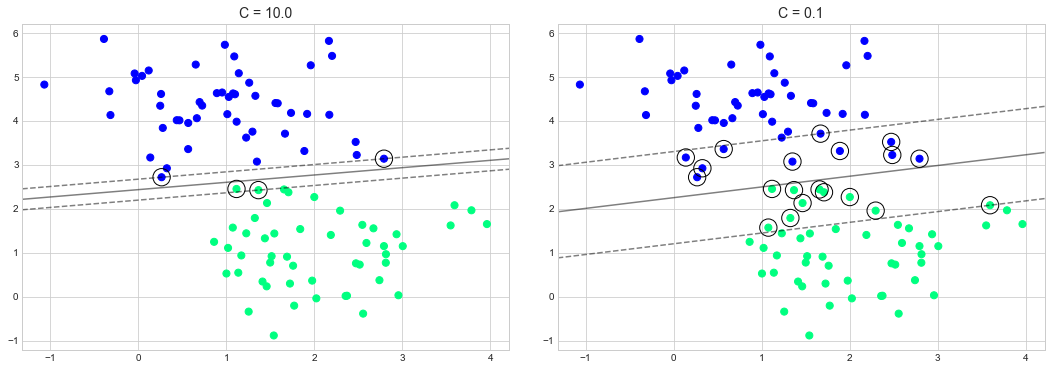

In [267]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

`C` 的最优值依赖于你的具体数据集，通常需要通过**交叉验证**等方法进行调参。



## 支持向量机（SVM）简明总结



### 优点

* **内存小，预测快**：只依赖少数支持向量。
* **高维适应性强**：尤其适用于特征维度大于样本数的任务。
* **借助核技巧灵活建模**：可处理复杂非线性边界。

### 缺点

* **训练开销大**：最坏时间复杂度为 \$\mathcal{O}(N^3)\$，常用实现也达 \$\mathcal{O}(N^2)\$。
* **参数依赖强**：如 `C`、核函数类型及参数，需仔细调参。
* **无直接概率输出**：若需概率输出（如分类置信度），需启用额外的估计过程（如 Platt scaling）。


### 使用建议

> **SVM不是首选**，但当其他简单快速的模型（如逻辑回归、决策树、随机森林、KNN 等）不能胜任时，SVM可以提供**强大且稳健的分类性能**，特别是在中小规模、维度高、边界复杂的任务中表现突出。


